DataLoaders

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models,datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import copy
from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Found GPU at: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU found, using CPU instead")

Found GPU at: Tesla T4


In [26]:
import os
import glob
import random
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [27]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Reading the direction for the images
tumor_dir = "/content/drive/MyDrive/brain tumor segmentation/archive (6) 2/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor"
healthy_dir = "/content/drive/MyDrive/brain tumor segmentation/archive (6) 2/Brain Tumor Data Set/Brain Tumor Data Set/Healthy"


In [29]:
# Filter only JPG files
tumor_images = glob.glob(os.path.join(tumor_dir, "*.jpg"))
healthy_images = glob.glob(os.path.join(healthy_dir, "*.jpg"))

# Labels
tumor_labels = [1] * len(tumor_images)  # 1 for tumor
healthy_labels = [0] * len(healthy_images)  # 0 for healthy

# Combine and split dataset
all_images = tumor_images + healthy_images
all_labels = tumor_labels + healthy_labels

# Split into training and validation sets (80% training, 20% validation)
train_images, val_images, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Create datasets
train_dataset = BrainTumorDataset(train_images, train_labels, transform=transform)
val_dataset = BrainTumorDataset(val_images, val_labels, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Vision transformers

In [30]:
!pip -q install vit_pytorch linformer

In [31]:
from vit_pytorch.efficient import ViT

In [32]:
from linformer import Linformer

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
import torch
from vit_pytorch import ViT
from vit_pytorch.mpp import MPP

model = ViT(
    image_size=224,
    patch_size=32,
    dim=1024,
    depth=6,
    heads=16,
    mlp_dim=2048,
    dropout=0.1,
    emb_dropout=0.1,
    channels = 3,
    num_classes = 2
).cuda()

batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [35]:
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [36]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [37]:
error = []
for epoch in range(10):
        print('epoch: ------', epoch)
        for ind, batch in enumerate(tqdm(train_loader)):
          imgs, label= batch
          images = imgs
          images = images.to(device=device, dtype=torch.float32)
          #print(images.shape)
          label = label.to(device = device, dtype = torch.long)
          output = model(images)
          #print('output', output)
          loss = criterion(output, label)
          if(ind ==0):
            error.append(loss.item())
            print(loss)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

epoch: ------ 0


  2%|▏         | 2/85 [00:09<05:15,  3.80s/it]

tensor(0.7584, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [03:53<00:00,  2.74s/it]


epoch: ------ 1


  2%|▏         | 2/85 [00:01<00:41,  1.98it/s]

tensor(0.4483, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:20<00:00,  4.24it/s]


epoch: ------ 2


  2%|▏         | 2/85 [00:00<00:33,  2.49it/s]

tensor(0.3423, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:20<00:00,  4.13it/s]


epoch: ------ 3


  2%|▏         | 2/85 [00:01<00:37,  2.21it/s]

tensor(0.1433, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:20<00:00,  4.21it/s]


epoch: ------ 4


  2%|▏         | 2/85 [00:01<00:40,  2.04it/s]

tensor(0.0141, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:24<00:00,  3.42it/s]


epoch: ------ 5


  1%|          | 1/85 [00:01<01:28,  1.05s/it]

tensor(0.0524, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:20<00:00,  4.11it/s]


epoch: ------ 6


  2%|▏         | 2/85 [00:01<00:37,  2.23it/s]

tensor(0.1973, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:20<00:00,  4.10it/s]


epoch: ------ 7


  2%|▏         | 2/85 [00:01<00:37,  2.19it/s]

tensor(0.0038, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:20<00:00,  4.18it/s]


epoch: ------ 8


  2%|▏         | 2/85 [00:00<00:35,  2.35it/s]

tensor(0.0153, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:20<00:00,  4.13it/s]


epoch: ------ 9


  2%|▏         | 2/85 [00:01<00:56,  1.48it/s]

tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:21<00:00,  4.04it/s]


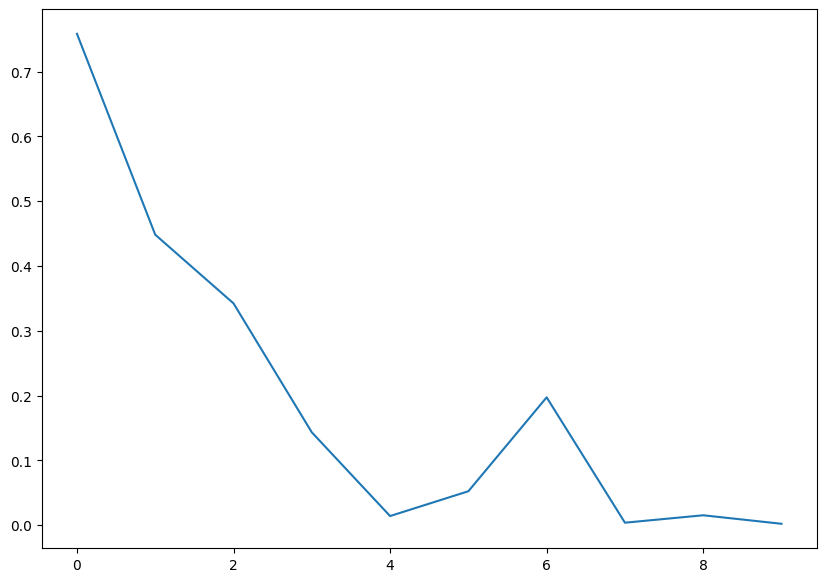

In [38]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(len(error)), error)
plt.show()

In [39]:
torch.save(model.state_dict(), 'ViT_model.pth')

In [40]:
model.eval()

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=3072, out_features=1024, bias=True)
    (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
     

In [41]:
pred = []
y_pred = []
y_true = []

with torch.no_grad():
    for data in tqdm(val_loader):
        img_np, label = data
        img = img_np.to(device=device, dtype=torch.float32)
        output = model(img)
        for i in range(len(output)):
            y_pred.append(output[i])
            y_true.append(label[i])

100%|██████████| 22/22 [00:04<00:00,  5.24it/s]


In [42]:
pred = []
for i in y_pred:
    pred.append(np.argmax(i.cpu().numpy()))
test = []
for i in y_true:
    test.append(i.numpy())

In [43]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test, pred))
from sklearn.metrics import classification_report
print(classification_report(test, pred))

[[355   9]
 [ 22 288]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       364
           1       0.97      0.93      0.95       310

    accuracy                           0.95       674
   macro avg       0.96      0.95      0.95       674
weighted avg       0.95      0.95      0.95       674



In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

Confusion Matrix:
[[355   9]
 [ 22 288]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       364
           1       0.97      0.93      0.95       310

    accuracy                           0.95       674
   macro avg       0.96      0.95      0.95       674
weighted avg       0.95      0.95      0.95       674



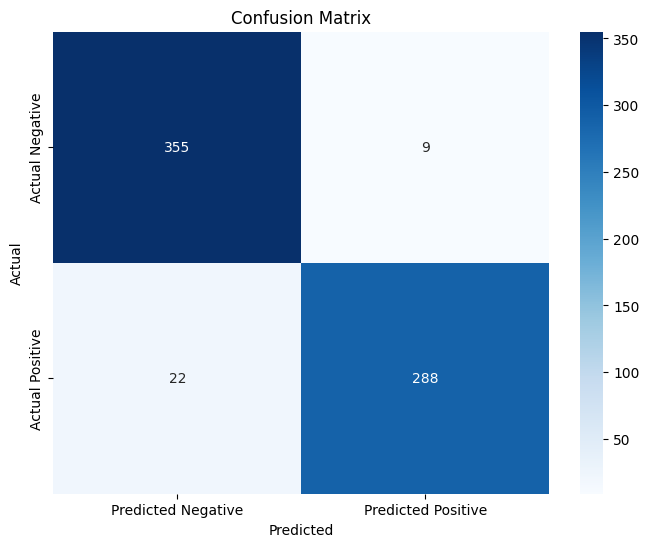


Accuracy: 0.9540
Precision: 0.9697
Recall: 0.9290
F1-score: 0.9489


In [45]:
# Вычисляем матрицу ошибок
cm = confusion_matrix(test, pred)

# Вычисляем метрики
accuracy = accuracy_score(test, pred)
precision = precision_score(test, pred)
recall = recall_score(test, pred)
f1 = f1_score(test, pred)

# Печатаем матрицу ошибок
print("Confusion Matrix:")
print(cm)

# Печатаем отчет о классификации
print("\nClassification Report:")
print(classification_report(test, pred))

# Визуализируем матрицу ошибок с помощью seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Печатаем вычисленные метрики
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

efficientnet

In [46]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=1ae7a249cf474da411e0ba24a6a4e25eebed2cbcd290ba8f3c650a9a780849e1
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [47]:
from efficientnet_pytorch import EfficientNet

In [48]:
best_results_efficientnet = {'epoch': 0, 'val_loss': float('inf'), 'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0}

model_efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
in_features = model_efficientnet._fc.in_features
model_efficientnet._fc = nn.Linear(in_features, 2)
model_efficientnet = model_efficientnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_efficientnet = optim.Adam(model_efficientnet.parameters(), lr=0.001)
scheduler_efficientnet = optim.lr_scheduler.StepLR(optimizer_efficientnet, step_size=3, gamma=0.1)



Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 467MB/s]

Loaded pretrained weights for efficientnet-b0


In [49]:
error = []
for epoch in range(10):
        print('epoch: ------', epoch)
        for ind, batch in enumerate(tqdm(train_loader)):
          imgs, label= batch
          images = imgs
          images = images.to(device=device, dtype=torch.float32)
          #print(images.shape)
          label = label.to(device = device, dtype = torch.long)
          output = model_efficientnet(images)
          #print('output', output)
          loss = criterion(output, label)
          if(ind ==0):
            error.append(loss.item())
            print(loss)
          optimizer_efficientnet.zero_grad()
          loss.backward()
          optimizer_efficientnet.step()

epoch: ------ 0


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor(0.6915, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:30<00:00,  2.81it/s]


epoch: ------ 1


  0%|          | 0/85 [00:00<?, ?it/s]

tensor(0.0395, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:32<00:00,  2.63it/s]


epoch: ------ 2


  1%|          | 1/85 [00:01<01:35,  1.14s/it]

tensor(0.1006, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:24<00:00,  3.46it/s]


epoch: ------ 3


  1%|          | 1/85 [00:00<01:16,  1.10it/s]

tensor(0.0137, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:24<00:00,  3.47it/s]


epoch: ------ 4


  1%|          | 1/85 [00:01<01:30,  1.07s/it]

tensor(0.0047, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:23<00:00,  3.68it/s]


epoch: ------ 5


  0%|          | 0/85 [00:00<?, ?it/s]

tensor(0.0240, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:25<00:00,  3.29it/s]


epoch: ------ 6


  1%|          | 1/85 [00:00<01:23,  1.00it/s]

tensor(0.0028, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:23<00:00,  3.59it/s]


epoch: ------ 7


  1%|          | 1/85 [00:01<01:24,  1.00s/it]

tensor(0.0182, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:25<00:00,  3.36it/s]


epoch: ------ 8


  1%|          | 1/85 [00:01<01:33,  1.11s/it]

tensor(0.0130, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:22<00:00,  3.70it/s]


epoch: ------ 9


  1%|          | 1/85 [00:01<01:30,  1.08s/it]

tensor(0.0073, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:22<00:00,  3.79it/s]


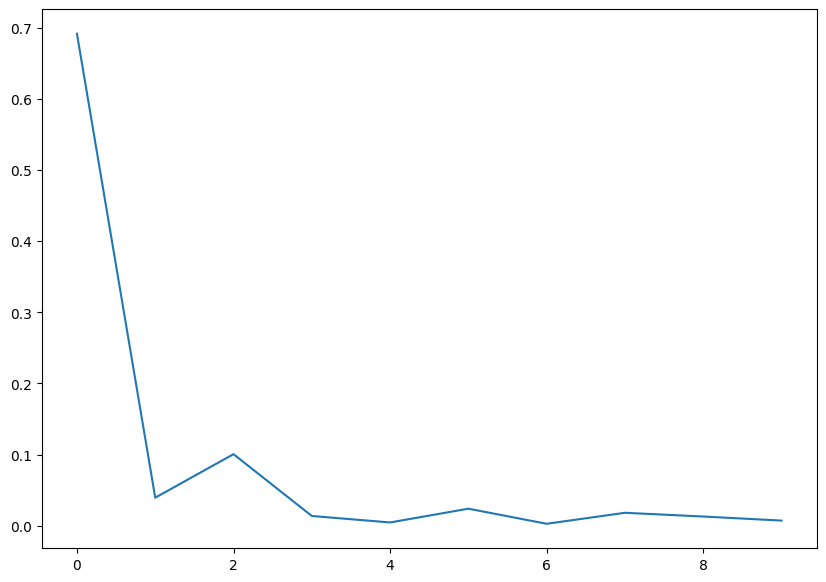

In [50]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(len(error)), error)
plt.show()

In [51]:
pred = []
y_pred = []
y_true = []

with torch.no_grad():
    for data in tqdm(val_loader):
        img_np, label = data
        img = img_np.to(device=device, dtype=torch.float32)
        output = model_efficientnet(img)
        for i in range(len(output)):
            y_pred.append(output[i])
            y_true.append(label[i])

100%|██████████| 22/22 [00:06<00:00,  3.16it/s]


In [52]:
pred = []
for i in y_pred:
    pred.append(np.argmax(i.cpu().numpy()))
test = []
for i in y_true:
    test.append(i.numpy())

In [53]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test, pred))
from sklearn.metrics import classification_report
print(classification_report(test, pred))

[[362   2]
 [  9 301]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       364
           1       0.99      0.97      0.98       310

    accuracy                           0.98       674
   macro avg       0.98      0.98      0.98       674
weighted avg       0.98      0.98      0.98       674



Confusion Matrix:
[[362   2]
 [  9 301]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       364
           1       0.99      0.97      0.98       310

    accuracy                           0.98       674
   macro avg       0.98      0.98      0.98       674
weighted avg       0.98      0.98      0.98       674



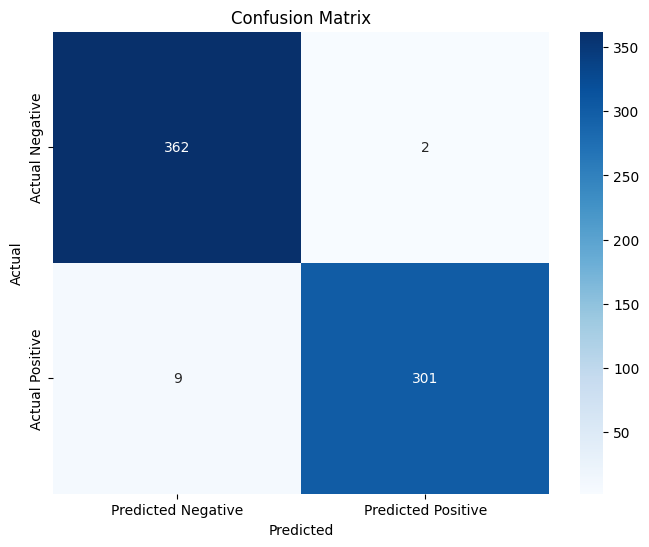


Accuracy: 0.9837
Precision: 0.9934
Recall: 0.9710
F1-score: 0.9821


In [54]:
# Вычисляем матрицу ошибок
cm = confusion_matrix(test, pred)

# Вычисляем метрики
accuracy = accuracy_score(test, pred)
precision = precision_score(test, pred)
recall = recall_score(test, pred)
f1 = f1_score(test, pred)

# Печатаем матрицу ошибок
print("Confusion Matrix:")
print(cm)

# Печатаем отчет о классификации
print("\nClassification Report:")
print(classification_report(test, pred))

# Визуализируем матрицу ошибок с помощью seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Печатаем вычисленные метрики
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

ResNet-50

In [55]:
model_resnet = models.resnet50(pretrained=True)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 2)  # Assuming 2 classes for brain tumor classification
model_resnet = model_resnet.to(device)

optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.001)
scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=3, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


In [56]:
error = []
for epoch in range(10):
        print('epoch: ------', epoch)
        for ind, batch in enumerate(tqdm(train_loader)):
          imgs, label= batch
          images = imgs
          images = images.to(device=device, dtype=torch.float32)
          #print(images.shape)
          label = label.to(device = device, dtype = torch.long)
          output = model_resnet(images)
          #print('output', output)
          loss = criterion(output, label)
          if(ind ==0):
            error.append(loss.item())
            print(loss)
          optimizer_resnet.zero_grad()
          loss.backward()
          optimizer_resnet.step()

epoch: ------ 0


  0%|          | 0/85 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor(0.7015, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:28<00:00,  2.99it/s]


epoch: ------ 1


  1%|          | 1/85 [00:01<02:30,  1.79s/it]

tensor(0.2525, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:28<00:00,  2.96it/s]


epoch: ------ 2


  1%|          | 1/85 [00:01<01:40,  1.19s/it]

tensor(0.0329, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:28<00:00,  3.03it/s]


epoch: ------ 3


  1%|          | 1/85 [00:01<02:46,  1.98s/it]

tensor(0.0455, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:28<00:00,  2.99it/s]


epoch: ------ 4


  1%|          | 1/85 [00:01<01:27,  1.04s/it]

tensor(0.0294, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:27<00:00,  3.06it/s]


epoch: ------ 5


  1%|          | 1/85 [00:00<01:21,  1.02it/s]

tensor(0.0595, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:27<00:00,  3.12it/s]


epoch: ------ 6


  1%|          | 1/85 [00:01<01:51,  1.33s/it]

tensor(0.0687, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:28<00:00,  2.95it/s]


epoch: ------ 7


  1%|          | 1/85 [00:00<01:22,  1.02it/s]

tensor(0.2274, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:27<00:00,  3.10it/s]


epoch: ------ 8


  1%|          | 1/85 [00:01<02:32,  1.82s/it]

tensor(0.0414, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:28<00:00,  3.00it/s]


epoch: ------ 9


  1%|          | 1/85 [00:01<01:35,  1.14s/it]

tensor(0.0662, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 85/85 [00:27<00:00,  3.05it/s]


In [57]:
pred = []
y_pred = []
y_true = []

with torch.no_grad():
    for data in tqdm(val_loader):
        img_np, label = data
        img = img_np.to(device=device, dtype=torch.float32)
        output = model_resnet(img)
        for i in range(len(output)):
            y_pred.append(output[i])
            y_true.append(label[i])
pred = []
for i in y_pred:
    pred.append(np.argmax(i.cpu().numpy()))
test = []
for i in y_true:
    test.append(i.numpy())

100%|██████████| 22/22 [00:06<00:00,  3.41it/s]


In [58]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test, pred))
from sklearn.metrics import classification_report
print(classification_report(test, pred))

[[361   3]
 [  8 302]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       364
           1       0.99      0.97      0.98       310

    accuracy                           0.98       674
   macro avg       0.98      0.98      0.98       674
weighted avg       0.98      0.98      0.98       674



Confusion Matrix:
[[361   3]
 [  8 302]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       364
           1       0.99      0.97      0.98       310

    accuracy                           0.98       674
   macro avg       0.98      0.98      0.98       674
weighted avg       0.98      0.98      0.98       674



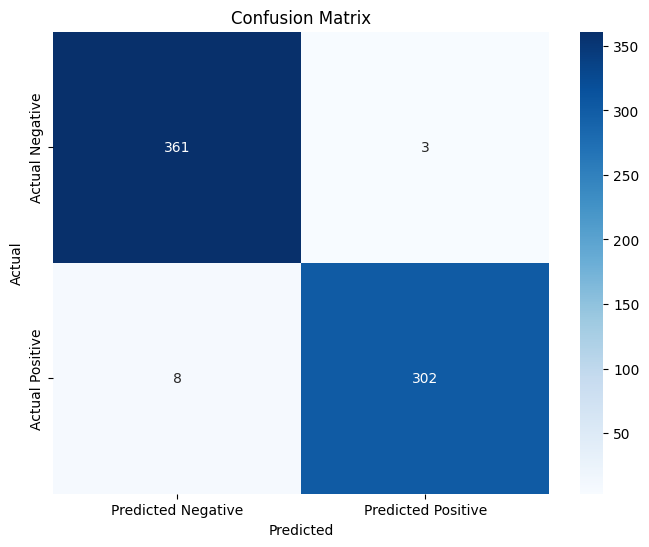


Accuracy: 0.9837
Precision: 0.9902
Recall: 0.9742
F1-score: 0.9821


In [59]:
# Вычисляем матрицу ошибок
cm = confusion_matrix(test, pred)

# Вычисляем метрики
accuracy = accuracy_score(test, pred)
precision = precision_score(test, pred)
recall = recall_score(test, pred)
f1 = f1_score(test, pred)

# Печатаем матрицу ошибок
print("Confusion Matrix:")
print(cm)

# Печатаем отчет о классификации
print("\nClassification Report:")
print(classification_report(test, pred))

# Визуализируем матрицу ошибок с помощью seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Печатаем вычисленные метрики
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

In [60]:
torch.save(model_resnet.state_dict(), 'model_resnet.pth')

In [61]:
torch.save(model_efficientnet.state_dict(), 'model_efficientnet.pth')

In [62]:
sum(p.numel() for p in model.parameters() if p.requires_grad)


53592066

In [63]:
sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)

23512130

In [64]:
sum(p.numel() for p in model_efficientnet.parameters() if p.requires_grad)

4010110

In [66]:
len(tumor_labels)+len(healthy_labels)


3369

In [67]:
len(tumor_labels)

1551

In [68]:
len(healthy_labels)


1818

Number of tumor images: 1551
Number of healthy images: 1818
Total number of images: 3369


<ipython-input-69-a155efe7e7bb>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Tumor', 'Healthy'], y=[num_tumor_images, num_healthy_images], palette="viridis")


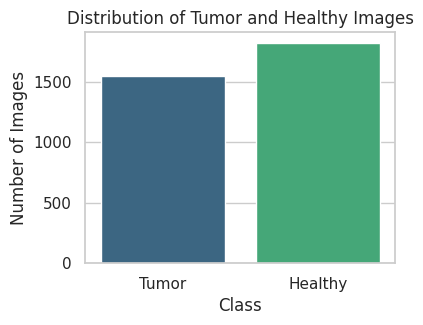

In [69]:
import seaborn as sns
# EDA: Count the number of images in each class
num_tumor_images = len(tumor_images)
num_healthy_images = len(healthy_images)
total_images = num_tumor_images + num_healthy_images

print(f"Number of tumor images: {num_tumor_images}")
print(f"Number of healthy images: {num_healthy_images}")
print(f"Total number of images: {total_images}")

# Plotting the distribution of images
sns.set(style="whitegrid")
plt.figure(figsize=(4, 3))
sns.barplot(x=['Tumor', 'Healthy'], y=[num_tumor_images, num_healthy_images], palette="viridis")
plt.title('Distribution of Tumor and Healthy Images')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.show()

In [70]:
len(train_images)

2695

In [71]:
len(val_images)

674